# COMP 7103 C 
**Assignment**

**Group 4**

In [1]:
# 创建Conda虚拟环境并添加到jupyter notebook kernal中

# ! conda create -n random_forest python=3.10
# !pip install ipykernel
# !python -m ipykernel install --name random_forest

# 配置环境后，需要重启jupyter notebook
# !conda env list

In [2]:
# !pip install scikit-learn

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf

In [4]:
# 1. Read data
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')
validate_data = pd.read_csv('Validate.csv')

For almost all the attributes, there is a possible value `nan` which means `unavailable`. 

For numeric columns, fill `nan` values with the `mean`; for categorical columns, fill `nan` values with the `mode`.

In [5]:
# 2. Data preprocessing
def preprocess_data(df):
    df = df.copy()
    
    # Handle missing values
    numeric_columns = ['Age', 'Years_of_Working ', 'Family_Members']
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].mean()) 
    
    categorical_columns = ['Profession', 'Graduate', 'Gender', 'Married']
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # Create LabelEncoder object
    le = LabelEncoder()
    
    # Convert string features to numeric
    encode_columns = ['Profession', 'Spending_Score', 'Category', 'Graduate', 'Gender', 'Married'] 
    for col in encode_columns:
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df

In [6]:
# Check missing values before preprocessing
print("Missing values before preprocessing:")
print(train_data.isnull().sum())

# Apply preprocessing
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)
validate_data = preprocess_data(validate_data)

# Check missing values after preprocessing
print("\nMissing values after preprocessing:")
print(train_data.isnull().sum())

Missing values before preprocessing:
ID                     0
Married                0
Gender               130
Age                    0
Graduate              77
Profession           112
Years_of_Working     742
Spending_Score         0
Family_Members       310
Category              72
Class(Target)          0
dtype: int64

Missing values after preprocessing:
ID                   0
Married              0
Gender               0
Age                  0
Graduate             0
Profession           0
Years_of_Working     0
Spending_Score       0
Family_Members       0
Category             0
Class(Target)        0
dtype: int64


In [7]:
# Process training, test and validation data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)
validate_data = preprocess_data(validate_data)

In [8]:
# print(train_data.columns.tolist())

# 3. Prepare features and target variables
feature_columns = ['ID', 'Married', 'Gender', 'Age', 'Graduate', 'Profession',
                  'Years_of_Working ', 'Spending_Score', 'Family_Members', 'Category']

X_train = train_data[feature_columns]
y_train = train_data['Class(Target)']

X_test = test_data[feature_columns]
X_validate = validate_data[feature_columns]
y_validate = validate_data['Class(Target)']


Parametric grid search using GridSearchCV

In [9]:
from sklearn.model_selection import GridSearchCV

# Define a relatively small parameter grid to speed up the search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

# Create random forest model
rf = RandomForestClassifier(random_state=42)

# Create grid search object, set n_jobs=1 to avoid parallel processing issues
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=1,  # Set to 1 to avoid parallel processing issues
    scoring='accuracy',
    verbose=2
)

# Train the grid search model
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Create new model with best parameters
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate optimized model
validate_predictions = best_rf.predict(X_validate)
validate_accuracy = accuracy_score(y_validate, validate_predictions)
print("\nOptimized validation set accuracy:", validate_accuracy)
print("\nOptimized classification report:")
print(classification_report(y_validate, validate_predictions))

# Output feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf.feature_importances_
})
print("\nFeature importance:")
print(feature_importance.sort_values('importance', ascending=False))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_lea

Based on the observation above,`Age`、`Profession` and `Years_of_Working` are most import features. Thus, here to try some 
optimizationstrategy like feature engineering.
- Create interaction features
- Perform binning on continuous variables (`Years_of_Working` column contains many duplicate values, which prevents proper binning. This can be resolved by adding the 'duplicates' parameter to handle these duplicate values.)
- Apply better encoding methods for categorical variables

The `recall` rate of `C` category is low, so need to find a way to enhance it. 

In [10]:
def feature_engineering(X):
    X = X.copy()
    
    # Age grouping with focus on more granular middle-age groups
    X['Age_Group'] = pd.qcut(X['Age'], q=6, labels=['Very_Young', 'Young', 'Middle_Young', 'Middle_Old', 'Senior', 'Elder'])
    
    # Work experience grouping with more detailed bins
    X['Experience_Level'] = pd.cut(X['Years_of_Working '], 
                                 bins=[0, 1, 3, 5, 7, 10, float('inf')],
                                 labels=['Entry', 'Junior', 'Mid_Junior', 'Mid', 'Senior', 'Expert'],
                                 include_lowest=True)
    
    # Create interaction features focusing on important variables
    X['Age_Experience_Ratio'] = X['Age'] / (X['Years_of_Working '] + 1)
    X['Age_Profession_Score'] = X['Age'] * X['Spending_Score']
    X['Experience_Spending'] = X['Years_of_Working '] * X['Spending_Score']
    
    # Create polynomial features for important numerical variables
    X['Age_Squared'] = X['Age'] ** 2
    X['Experience_Squared'] = X['Years_of_Working '] ** 2
    
    # Profession-based features
    X['Profession'] = X['Profession'].astype('category')
    profession_mapping = X.groupby('Profession', observed=True)['Spending_Score'].mean()
    X['Profession_Spending_Mean'] = X['Profession'].map(profession_mapping)
    
    # Encode categorical variables
    cat_columns = ['Profession', 'Graduate', 'Age_Group', 'Experience_Level']
    X = pd.get_dummies(X, columns=cat_columns)
    
    return X

# Define class weights to focus on Class C
class_weights = {
    'A': 1,
    'B': 1,
    'C': 3,  # Higher weight for Class C
    'D': 1
}

# Modified parameter grid with fewer combinations
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [15, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'class_weight': [class_weights]
}

# Create and train model
rf = RandomForestClassifier(random_state=42)

# Create GridSearchCV with reduced parallel processing
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=1,  # Disable parallel processing
    scoring='recall_macro',  # Use built-in scoring instead of custom scorer
    verbose=2
)

# Apply feature engineering
X_train_engineered = feature_engineering(X_train)
X_validate_engineered = feature_engineering(X_validate)

# Train model
grid_search.fit(X_train_engineered, y_train)

# Output results
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Create new model with best parameters
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train_engineered, y_train)

# Evaluate optimized model
validate_predictions = best_rf.predict(X_validate_engineered)
validate_accuracy = accuracy_score(y_validate, validate_predictions)
print("\nOptimized Validation Set Accuracy:", validate_accuracy)
print("\nClassification Report:")
print(classification_report(y_validate, validate_predictions))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train_engineered.columns,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 15 Important Features:")
print(feature_importance.head(15))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END class_weight={'A': 1, 'B': 1, 'C': 3, 'D': 1}, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.5s
[CV] END class_weight={'A': 1, 'B': 1, 'C': 3, 'D': 1}, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END class_weight={'A': 1, 'B': 1, 'C': 3, 'D': 1}, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END class_weight={'A': 1, 'B': 1, 'C': 3, 'D': 1}, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.5s
[CV] END class_weight={'A': 1, 'B': 1, 'C': 3, 'D': 1}, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END class_weight={'A': 1, 'B': 1, 'C': 3, 'D': 1}, max_depth=15, max_features=sqrt, min_samples_leaf

This is for category variable feature engineering.

In [11]:
from sklearn.model_selection import RandomizedSearchCV

def feature_engineering(X):
    X = X.copy()
    
    # Remove ID as it's showing high importance but likely not meaningful
    X = X.drop('ID', axis=1)
    
    # Enhanced Age features based on importance analysis 
    X['Age_Group'] = pd.qcut(X['Age'], q=8, labels=['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8'])
    X['Age_Squared'] = X['Age'] ** 2
    X['Age_Cubed'] = X['Age'] ** 3
    
    # Enhanced Experience features
    X['Experience_Level'] = pd.cut(X['Years_of_Working '], 
                                 bins=[0, 2, 4, 6, 8, 10, float('inf')],
                                 labels=['E1', 'E2', 'E3', 'E4', 'E5', 'E6'],
                                 include_lowest=True)
    
    # Improved interaction features
    X['Age_Experience_Ratio'] = X['Age'] / (X['Years_of_Working '] + 1)
    X['Age_Family_Ratio'] = X['Age'] / (X['Family_Members'] + 1)
    X['Experience_Family_Ratio'] = X['Years_of_Working '] / (X['Family_Members'] + 1)
    X['Age_Experience_Product'] = X['Age'] * X['Years_of_Working ']
    X['Age_Experience_Difference'] = X['Age'] - X['Years_of_Working ']
    
    # Enhanced spending-related features
    X['Spending_per_Family'] = X['Spending_Score'] / (X['Family_Members'] + 1)
    X['Age_Spending_Ratio'] = X['Age'] * X['Spending_Score']
    
    # Binary features interaction
    X['Married_Graduate'] = X['Married'] * X['Graduate']

    # statistic features
    for col in ['Profession', 'Category']:
        # 添加更多统计特征
        group_median = X.groupby(col)['Spending_Score'].median()
        group_q75 = X.groupby(col)['Spending_Score'].quantile(0.75)
        group_q25 = X.groupby(col)['Spending_Score'].quantile(0.25)
        X[f'{col}_spending_median'] = X[col].map(group_median)
        X[f'{col}_spending_q75'] = X[col].map(group_q75)
        X[f'{col}_spending_q25'] = X[col].map(group_q25)
        X[f'{col}_spending_iqr'] = X[f'{col}_spending_q75'] - X[f'{col}_spending_q25']
    
    # Comprehensive categorical encoding
    categorical_cols = ['Profession', 'Graduate', 'Age_Group', 'Experience_Level', 'Category']
    
    def comprehensive_categorical_engineering(X, categorical_cols):
        X = X.copy()
        
        # 1. Base encodings
        for col in categorical_cols:
            # Frequency encoding
            freq = X[col].value_counts(normalize=True)
            X[f'{col}_freq'] = X[col].map(freq)
            
            # Count encoding
            counts = X[col].value_counts()
            X[f'{col}_count'] = X[col].map(counts)
            
            # Spending score statistics per category
            if col in ['Profession', 'Category']:
                group_means = X.groupby(col)['Spending_Score'].mean()
                group_stds = X.groupby(col)['Spending_Score'].std()
                X[f'{col}_spending_mean'] = X[col].map(group_means)
                X[f'{col}_spending_std'] = X[col].map(group_stds)
        
        # 2. One-hot encoding for original categorical columns
        X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols)
        
        return X
    
    X = comprehensive_categorical_engineering(X, categorical_cols)
    
    # Drop highly correlated features
    X = X.drop(['Experience_Squared'], axis=1, errors='ignore')
    
    return X

# Define class weights to focus on Class C
class_weights = {
    'A': 1,
    'B': 1, 
    'C': 3,
    'D': 2
}

# Modified parameter grid
param_grid = {
    'n_estimators': [400, 500, 600, 700, 1000, 1500],
    'max_depth': [5, 10, 15, 20, 25, 30, 50, 100],
    'min_samples_split': [2, 3, 5, 10],  
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [{
        'A': 1,
        'B': 1,
        'C': 4,
        'D': 1
    },
    {
        'A': 1,
        'B': 1,
        'C': 3,
        'D': 2
    },
    {
        'A': 2,
        'B': 1,
        'C': 4,
        'D': 2
    }],
    'bootstrap': [True],  # 只使用True
    'max_samples': [0.7, 0.8, 0.9, None]  # 只在bootstrap=True时使用
}

# Create and train model
rf = RandomForestClassifier(random_state=42)

# Create GridSearchCV with reduced parallel processing
grid_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    cv=5,
    n_iter=500,
    n_jobs=1, 
    scoring='recall_macro',
    verbose=2,
    random_state=42
)

# Apply feature engineering
X_train_engineered = feature_engineering(X_train)
X_validate_engineered = feature_engineering(X_validate)

# Train model
grid_search.fit(X_train_engineered, y_train)

# Output results
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END bootstrap=True, class_weight={'A': 2, 'B': 1, 'C': 4, 'D': 2}, max_depth=10, max_features=log2, max_samples=0.9, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   2.1s
[CV] END bootstrap=True, class_weight={'A': 2, 'B': 1, 'C': 4, 'D': 2}, max_depth=10, max_features=log2, max_samples=0.9, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   2.3s
[CV] END bootstrap=True, class_weight={'A': 2, 'B': 1, 'C': 4, 'D': 2}, max_depth=10, max_features=log2, max_samples=0.9, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   2.1s
[CV] END bootstrap=True, class_weight={'A': 2, 'B': 1, 'C': 4, 'D': 2}, max_depth=10, max_features=log2, max_samples=0.9, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=   2.1s
[CV] END bootstrap=True, class_weight={'A': 2, 'B': 1, 'C': 4, 'D': 2}, max_depth=10, max_features=log2, max_samples=0.9, min_sample

Best Score: 0.4491671424300182

- Adjust confidence threshold: 0.7 may be too high, consider lowering it to 0.5 or 0.6

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def validate_rf_voting(model, X_validate, y_validate, thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    Validate Random Forest model's voting patterns and prediction confidence for multiple thresholds
    """
    # Convert X_validate to numpy array without feature names to avoid warnings
    X_validate_array = X_validate.values if hasattr(X_validate, 'values') else X_validate

    # Get predictions and probabilities 
    y_pred = model.predict(X_validate)
    y_prob = model.predict_proba(X_validate)

    # Get individual tree predictions using numpy array
    tree_predictions = np.array([tree.predict(X_validate_array) for tree in model.estimators_])

    # Map class labels to integers for bincount
    label_to_int = {label: idx for idx, label in enumerate(model.classes_)}
    int_to_label = {idx: label for label, idx in label_to_int.items()}

    # Convert float predictions to integers directly
    tree_predictions_int = tree_predictions.astype(int)

    # Calculate voting statistics
    n_trees = len(model.estimators_)
    voting_stats = {}

    # Analyze voting patterns for each sample
    for idx in range(len(X_validate)):
        true_label = y_validate.iloc[idx]
        predicted_label = y_pred[idx]
        tree_votes = tree_predictions_int[:, idx]
        
        # Count votes for each class
        vote_counts = np.bincount(tree_votes, minlength=len(model.classes_))
        winning_votes = max(vote_counts)
        total_votes = sum(vote_counts)
        
        # Calculate voting confidence
        vote_confidence = winning_votes / total_votes
        
        # Create class distribution using original class labels
        class_distribution = {model.classes_[i]: count/total_votes 
                            for i, count in enumerate(vote_counts)}
        
        # Store statistics
        if idx not in voting_stats:
            voting_stats[idx] = {
                'true_label': true_label,
                'predicted_label': predicted_label,
                'vote_confidence': vote_confidence,
                'vote_distribution': vote_counts / total_votes,
                'class_distribution': class_distribution
            }

    # Store results for each threshold
    threshold_results = {}
    
    for threshold in thresholds:
        results = {
            'high_confidence_correct': 0,
            'high_confidence_incorrect': 0,
            'low_confidence_correct': 0,
            'low_confidence_incorrect': 0,
            'confidence_threshold': threshold
        }
        
        # Evaluate predictions
        for stats in voting_stats.values():
            is_correct = stats['true_label'] == stats['predicted_label']
            is_high_confidence = stats['vote_confidence'] >= threshold
            
            if is_high_confidence and is_correct:
                results['high_confidence_correct'] += 1
            elif is_high_confidence and not is_correct:
                results['high_confidence_incorrect'] += 1
            elif not is_high_confidence and is_correct:
                results['low_confidence_correct'] += 1
            else:
                results['low_confidence_incorrect'] += 1

        total_samples = len(X_validate)
        
        # Calculate confidence metrics
        total_high_conf = results['high_confidence_correct'] + results['high_confidence_incorrect']
        total_low_conf = results['low_confidence_correct'] + results['low_confidence_incorrect']
        
        high_conf_accuracy = results['high_confidence_correct'] / total_high_conf if total_high_conf > 0 else 0
        low_conf_accuracy = results['low_confidence_correct'] / total_low_conf if total_low_conf > 0 else 0
        overall_accuracy = (results['high_confidence_correct'] + results['low_confidence_correct']) / total_samples
        print("total_samples: ",total_samples, "results['high_confidence_correct']: ", results['high_confidence_correct'], "results['low_confidence_correct']: ", results['low_confidence_correct'])
        
        threshold_results[threshold] = {
            'overall_accuracy': overall_accuracy,
            'high_conf_accuracy': high_conf_accuracy,
            'low_conf_accuracy': low_conf_accuracy,
            'total_high_conf': total_high_conf,
            'total_low_conf': total_low_conf
        }

    # Print results for each threshold
    print("\nResults for different confidence thresholds:")
    print("-------------------------------------------")
    for threshold, metrics in threshold_results.items():
        print(f"\nThreshold: {threshold}")
        print(f"Overall accuracy: {metrics['overall_accuracy']:.5f}")
        print(f"High confidence accuracy: {metrics['high_conf_accuracy']:.5f} (samples: {metrics['total_high_conf']})")
        print(f"Low confidence accuracy: {metrics['low_conf_accuracy']:.5f} (samples: {metrics['total_low_conf']})")

    # Create visualization
    plt.figure(figsize=(10, 6))
    thresholds_list = list(threshold_results.keys())
    overall_accuracies = [threshold_results[t]['overall_accuracy'] for t in thresholds_list]
    high_conf_accuracies = [threshold_results[t]['high_conf_accuracy'] for t in thresholds_list]
    low_conf_accuracies = [threshold_results[t]['low_conf_accuracy'] for t in thresholds_list]

    plt.plot(thresholds_list, overall_accuracies, 'b-', label='Overall Accuracy', marker='o')
    plt.plot(thresholds_list, high_conf_accuracies, 'g-', label='High Confidence Accuracy', marker='s')
    plt.plot(thresholds_list, low_conf_accuracies, 'r-', label='Low Confidence Accuracy', marker='^')

    plt.xlabel('Confidence Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Confidence Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    return threshold_results, voting_stats

total_samples:  1069 results['high_confidence_correct']:  215 results['low_confidence_correct']:  280
total_samples:  1069 results['high_confidence_correct']:  150 results['low_confidence_correct']:  345
total_samples:  1069 results['high_confidence_correct']:  92 results['low_confidence_correct']:  403
total_samples:  1069 results['high_confidence_correct']:  61 results['low_confidence_correct']:  434
total_samples:  1069 results['high_confidence_correct']:  35 results['low_confidence_correct']:  460
total_samples:  1069 results['high_confidence_correct']:  4 results['low_confidence_correct']:  491

Results for different confidence thresholds:
-------------------------------------------

Threshold: 0.5
Overall accuracy: 0.46305
High confidence accuracy: 0.61960 (samples: 347)
Low confidence accuracy: 0.38781 (samples: 722)

Threshold: 0.55
Overall accuracy: 0.46305
High confidence accuracy: 0.71429 (samples: 210)
Low confidence accuracy: 0.40163 (samples: 859)

Threshold: 0.6
Overall 

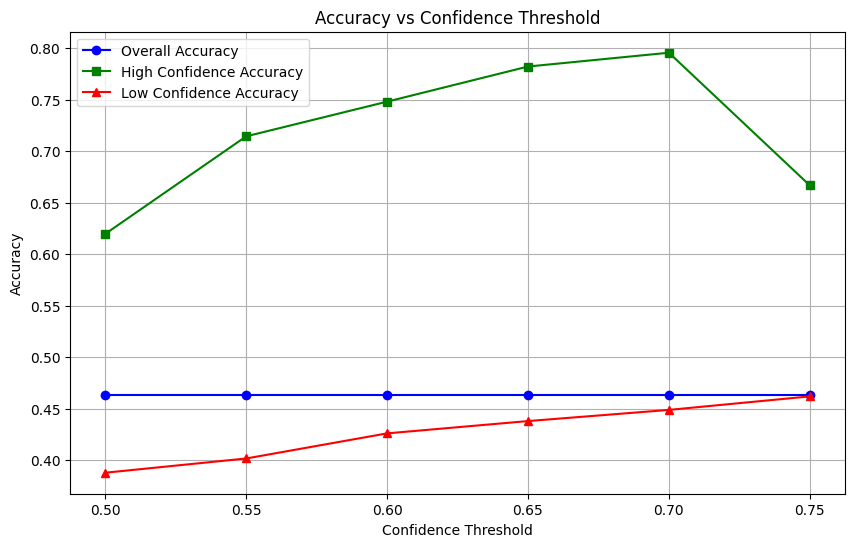

In [31]:
best_model = grid_search.best_estimator_
results, voting_stats = validate_rf_voting(best_model, X_validate_engineered, y_validate)